In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime # to time processes
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
foo =r'C:\Users\ACER\Desktop\python project\airqo/BugolobiHOULY.csv'

In [4]:
pjme = pd.read_csv(foo, index_col=[0], parse_dates=[0])

In [7]:
pjme

,s2_pm2_5
Date,
2019-03-12 09:00:00,19.975000
2019-03-12 11:00:00,15.408571
2019-03-12 12:00:00,14.654348
2019-03-12 13:00:00,14.365435
2019-03-12 14:00:00,15.451739
...,...
2019-03-19 16:00:00,34.651304
2019-03-19 17:00:00,40.095778
2019-03-19 18:00:00,38.870652


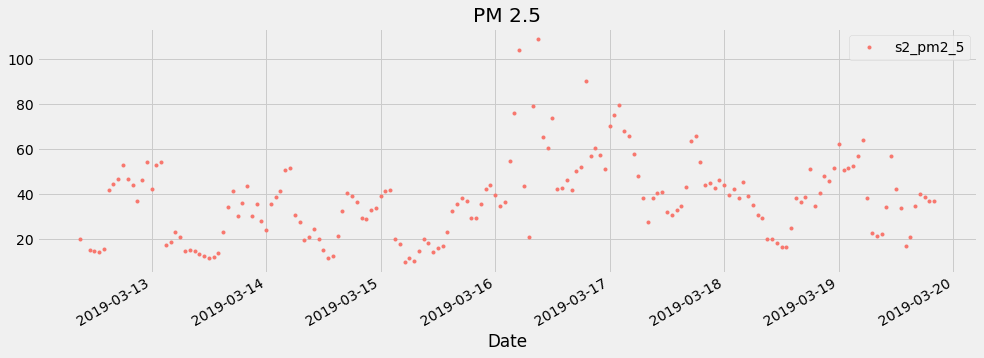

In [5]:
# Plotting timeseries
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
temp_plot = pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='PM 2.5')

# Train/Test Split

In [6]:
split_date = '18-03-2019'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

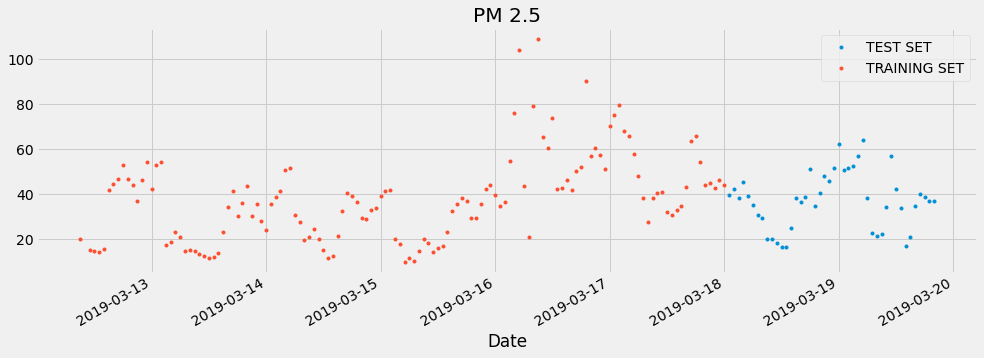

In [8]:
temp_plot = pjme_test \
    .rename(columns={'s2_pm2_5': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'s2_pm2_5': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='PM 2.5', style='.')

# Create Features

In [9]:
def create_features(df, label=None):
    """Creates time series from a datetime index"""
    df['Date'] = df.index
    df['hour'] = df['Date'].dt.hour
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['quarter'] = df['Date'].dt.quarter
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['dayofyear'] = df['Date'].dt.dayofyear
    df['dayofmonth'] = df['Date'].dt.day
    df['weekofyear'] = df['Date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    
    if label:
        y = df[label]
        return X, y
    
    return X

In [10]:
X_train, y_train = create_features(pjme_train, label='s2_pm2_5')
X_test, y_test = create_features(pjme_test, label='s2_pm2_5')

# Create RFR Models and Predict

In [15]:
# Model 1 - Depth 2
start = datetime.datetime.now()
reg = RandomForestRegressor(max_depth=2, random_state=0, n_estimators=100)
reg.fit(X_train, y_train)
end = datetime.datetime.now()
print("Total runtime for reg (depth=2, estimators=100): ", end-start)

Total runtime for reg (depth=2, estimators=100):  0:00:00.219417


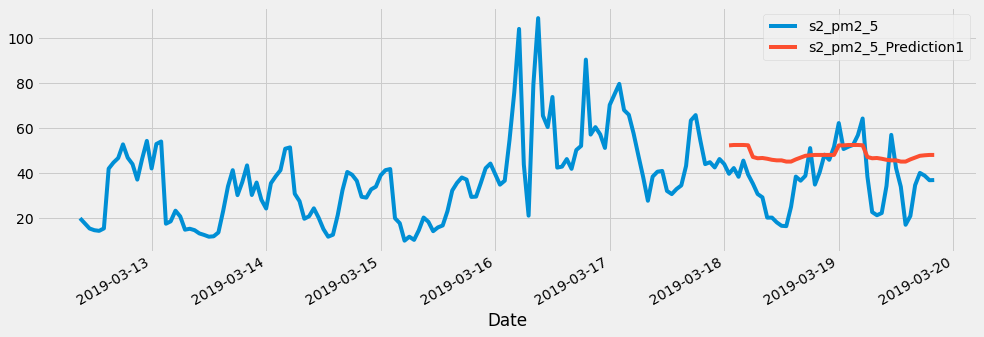

In [16]:
# Plot Reg 1
pjme_test['s2_pm2_5_Prediction1'] = reg.predict(X_test)
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)
temp_plot = pjme_all[['s2_pm2_5','s2_pm2_5_Prediction1']].plot(figsize=(15, 5))

In [17]:
# Model 2 - Depth 10
start = datetime.datetime.now()
reg2 = RandomForestRegressor(max_depth=10, random_state=0, n_estimators=100)
reg2.fit(X_train, y_train)
end = datetime.datetime.now()
print("Total runtime for reg2 (depth=10, estimators=100): ", end-start)

Total runtime for reg2 (depth=10, estimators=100):  0:00:00.292157


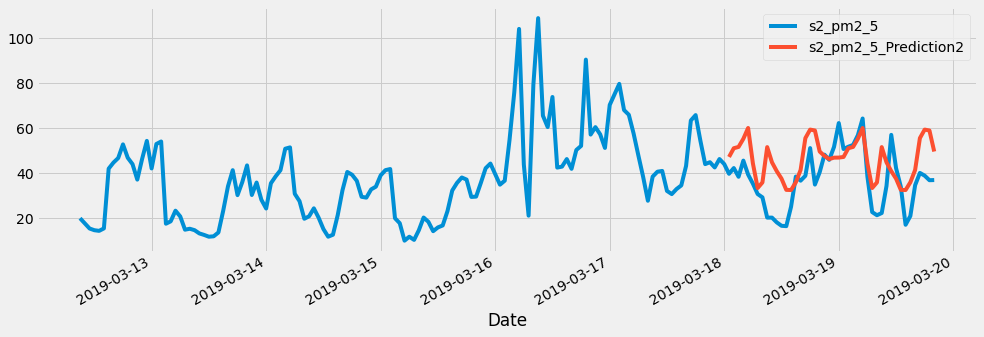

In [18]:
# Plot Reg 2
pjme_test['s2_pm2_5_Prediction2'] = reg2.predict(X_test)
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)
temp_plot = pjme_all[['s2_pm2_5','s2_pm2_5_Prediction2']].plot(figsize=(15, 5))

In [19]:
# Model 3 - Depth 10
start = datetime.datetime.now()
reg3 = RandomForestRegressor(max_depth=2, random_state=0, n_estimators=1000)
reg3.fit(X_train, y_train)
end = datetime.datetime.now()
print("Total runtime for reg2 (depth=2, estimators=1000): ", end-start)

Total runtime for reg2 (depth=2, estimators=1000):  0:00:02.140900


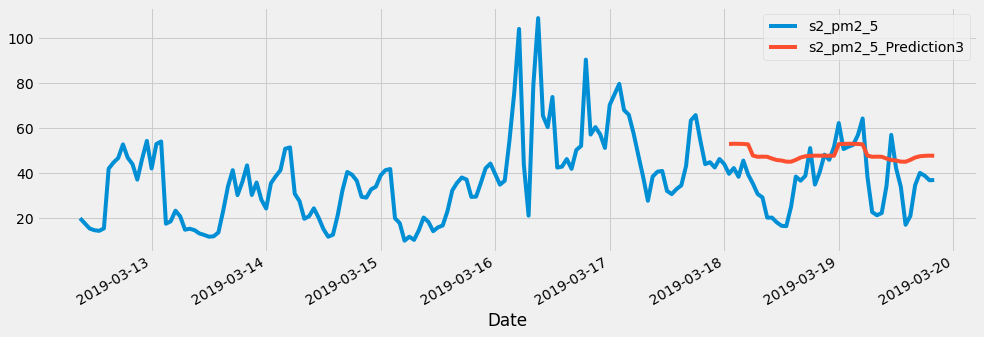

In [20]:
# Plot Reg 3
pjme_test['s2_pm2_5_Prediction3'] = reg3.predict(X_test)
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)
temp_plot = pjme_all[['s2_pm2_5','s2_pm2_5_Prediction3']].plot(figsize=(15, 5))

In [21]:
# Model 4 - Depth = 10, Estimators = 1000
start = datetime.datetime.now()
reg4 = RandomForestRegressor(max_depth=10, random_state=0, n_estimators=1000)
reg4.fit(X_train, y_train)
end = datetime.datetime.now()
print("Total runtime for reg3 (depth=10, estimators=1000): ", end-start)

Total runtime for reg3 (depth=10, estimators=1000):  0:00:02.522523


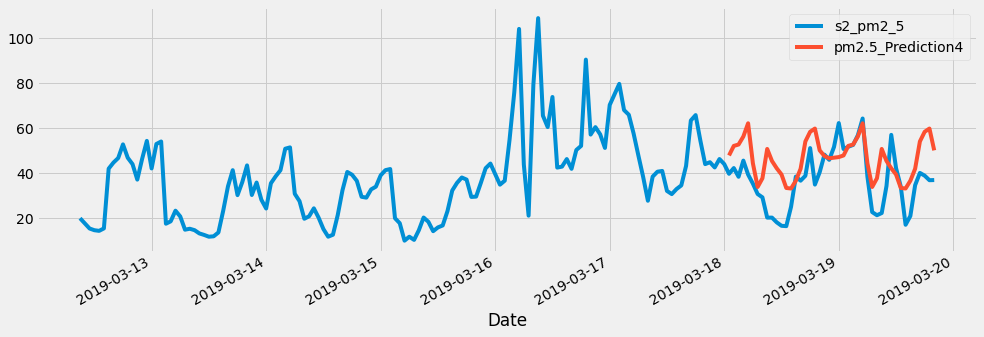

In [22]:
# Plot Reg 4
pjme_test['pm2.5_Prediction4'] = reg4.predict(X_test)
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)
temp_plot = pjme_all[['s2_pm2_5','pm2.5_Prediction4']].plot(figsize=(15, 5))

# Evaluate Model PerformancE

In [23]:
import math

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

for i in ['s2_pm2_5_Prediction1', 's2_pm2_5_Prediction2', 's2_pm2_5_Prediction3', 'pm2.5_Prediction4']:
    print(i)
    print("MSE: ", mean_squared_error(y_true=pjme_test['s2_pm2_5'], y_pred=pjme_test[i]))
    print("RMSE: ", math.sqrt(mean_squared_error(y_true=pjme_test['s2_pm2_5'], y_pred=pjme_test[i])))
    print("MAE: ", mean_absolute_error(y_true=pjme_test['s2_pm2_5'], y_pred=pjme_test[i]))
    print("Mean Absolute Percentage Error: {}%".format(round(mean_absolute_percentage_error(pjme_test['s2_pm2_5'], pjme_test[i]), 4)))
    print("\n")
    
    

s2_pm2_5_Prediction1
MSE:  239.57381413939444
RMSE:  15.478172183413468
MAE:  12.919836720395825
Mean Absolute Percentage Error: 49.71%


s2_pm2_5_Prediction2
MSE:  194.76839621788574
RMSE:  13.955944834295016
MAE:  11.351595594683117
Mean Absolute Percentage Error: 40.6257%


s2_pm2_5_Prediction3
MSE:  245.16037407066162
RMSE:  15.657597966184392
MAE:  13.084554691515065
Mean Absolute Percentage Error: 50.3119%


pm2.5_Prediction4
MSE:  202.05617322361923
RMSE:  14.21464643329616
MAE:  11.481948893748937
Mean Absolute Percentage Error: 41.6033%




# Plotting Residuals

In [24]:
# Note: we use MW_Prediction4 for this as it has the largest depth and estimators
pjme_test['error1'] = pjme_test['s2_pm2_5_Prediction1'] - pjme_test['s2_pm2_5']
pjme_test['error3'] = pjme_test['s2_pm2_5_Prediction3'] - pjme_test['s2_pm2_5']

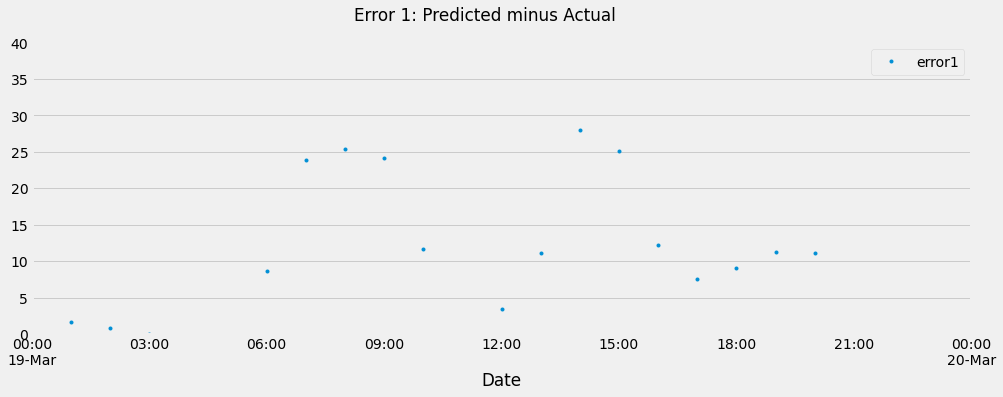

In [26]:
# Plot the forecast against the actual observations
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
temp_plot = pjme_test[['error1']].plot(ax=ax,
                                              style=['.'])
ax.set_xbound(lower='03-19-2019', upper='03-20-2019')
ax.set_ylim(0, 40)
plot = plt.suptitle('Error 1: Predicted minus Actual')

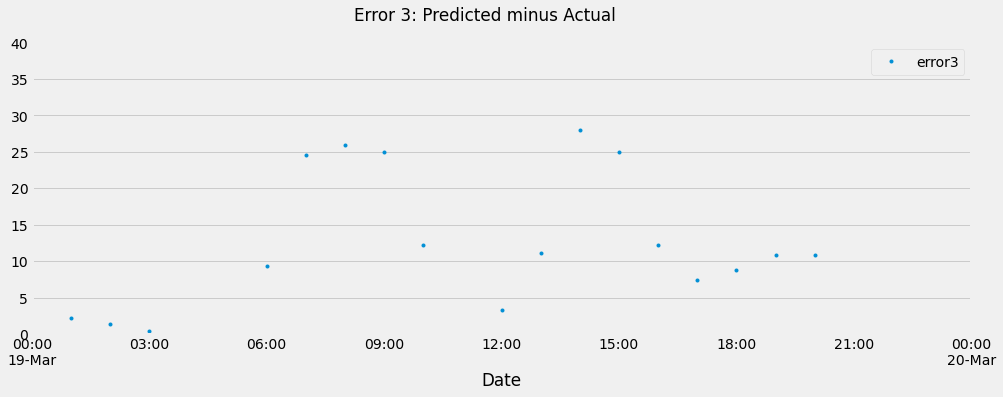

In [27]:
# Plot the forecast against the actual observations
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
temp_plot = pjme_test[['error3']].plot(ax=ax,
                                              style=['.'])
ax.set_xbound(lower='03-19-2019', upper='03-20-2019')
ax.set_ylim(0, 40)
plot = plt.suptitle('Error 3: Predicted minus Actual')

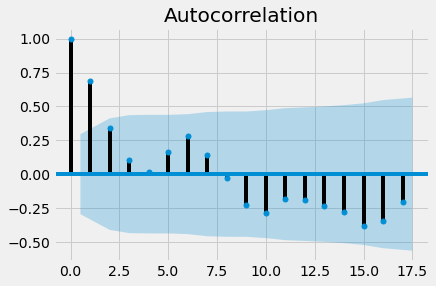

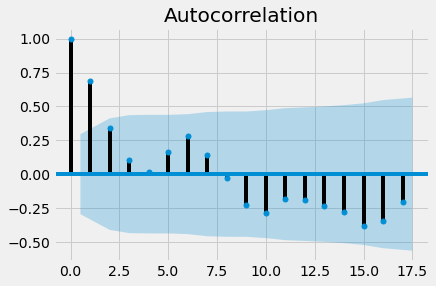

In [31]:
# Plotting Autocorrelation
# Autocorrelation = 1 is perfect correlation
from statsmodels.graphics.tsaplots import plot_acf
series = pjme_test['error3']
plot_acf(series)

# Durbin Watson Test¶

In [34]:
from statsmodels.stats.stattools import durbin_watson

durbin_watson(pjme_test['error1'])

0.31732453272104333

In [33]:
from statsmodels.stats.stattools import durbin_watson

durbin_watson(pjme_test['error3'])

0.3124493103741166

Mean Absolute Percentage Error: 0.31%